In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
np.seterr(divide="ignore")
import logging
import pickle
import glob

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.utils import check_random_state

from scipy import interp

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 6)

In [3]:
def evaluate_models(pattern):
    rocs = []
    fprs = []
    tprs = []
    
    for filename in glob.glob(pattern):            
        data = pickle.load(open(filename, "rb"))
        y = data[:, 0]
        y_pred = data[:, 1]
        
        # Roc
        rocs.append(roc_auc_score(y, y_pred))
        fpr, tpr, _ = roc_curve(y, y_pred)
        
        fprs.append(fpr)
        tprs.append(tpr)
        
    return rocs, fprs, tprs

def plot_rocs(rocs, fprs, tprs, label="", color="r", show_all=False):
    inv_fprs = []
    base_tpr = np.linspace(0.05, 1, 476)
    
    for fpr, tpr in zip(fprs, tprs):
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
        if show_all:
            plt.plot(base_tpr, inv_fpr, alpha=0.1, color=color)
        
    inv_fprs = np.array(inv_fprs)
    mean_inv_fprs = inv_fprs.mean(axis=0)


    plt.plot(base_tpr, mean_inv_fprs, color, 
             label="%s" % label)
    
def plot_show(filename=None):
    plt.xlabel("Signal efficiency")
    plt.ylabel("1 / Background efficiency")
    plt.xlim([0.1, 1.0])
    plt.yscale("log")
    plt.legend(loc="best")
    plt.grid()
    
    if filename:
        plt.savefig(filename)
    
    plt.show()
    
def report_score(rocs, fprs, tprs, label, latex=False):       
    inv_fprs = []
    base_tpr = np.linspace(0.05, 1, 476)
    
    for fpr, tpr in zip(fprs, tprs):
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
        
    inv_fprs = np.array(inv_fprs)
    mean_inv_fprs = inv_fprs.mean(axis=0)
    
    if not latex:
        print("%32s\tROC AUC=%.4f+-%.2f\t1/FPR@TPR=0.5=%.2f+-%.2f" %  (label, 
                                                                       np.mean(rocs), 
                                                                       np.std(rocs),
                                                                       np.mean(inv_fprs[:, 225]),
                                                                       np.std(inv_fprs[:, 225])))
    else:
        print("%30s \t& %.4f $\pm$ %.4f \t& %.1f $\pm$ %.1f \\\\" % 
              (label,
               np.mean(rocs), 
               np.std(rocs),
               np.mean(inv_fprs[:, 225]),
               np.std(inv_fprs[:, 225])))

                 1 & particles 	& 0.9602 $\pm$ 0.0004 	& 195.9 $\pm$ 8.0 \\
                    1 & towers 	& 0.9500 $\pm$ 0.0008 	& 128.1 $\pm$ 4.2 \\
              1 & towers+pflow 	& 0.9514 $\pm$ 0.0012 	& 133.5 $\pm$ 6.5 \\


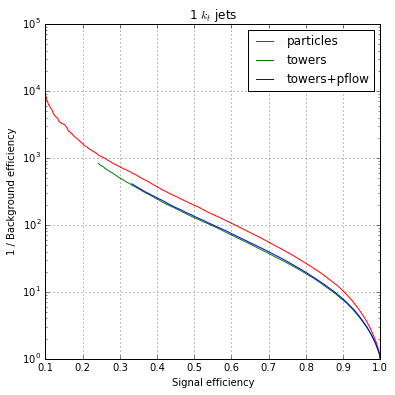

                 2 & particles 	& 0.9866 $\pm$ 0.0007 	& 2521.5 $\pm$ 450.2 \\
                    2 & towers 	& 0.9837 $\pm$ 0.0003 	& 1597.2 $\pm$ 294.7 \\
              2 & towers+pflow 	& 0.9846 $\pm$ 0.0004 	& 1718.9 $\pm$ 222.9 \\


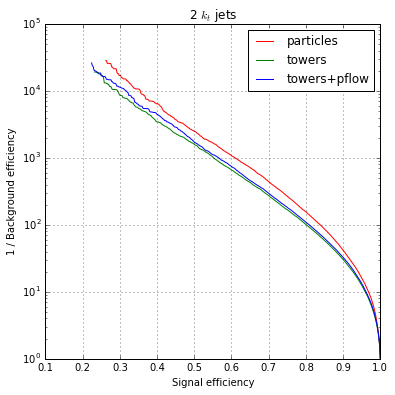

                 5 & particles 	& 0.9867 $\pm$ 0.0004 	& 2592.1 $\pm$ 433.3 \\
                    5 & towers 	& 0.9817 $\pm$ 0.0005 	& 1190.8 $\pm$ 159.5 \\
              5 & towers+pflow 	& 0.9828 $\pm$ 0.0007 	& 1146.4 $\pm$ 142.7 \\


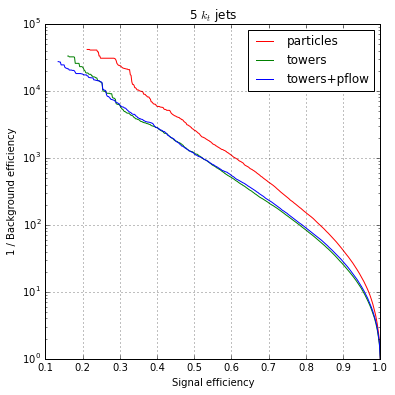

In [16]:
for n_jets in [1, 2, 5]:
    for pattern, label, color in [
            ("antikt-kt", "particles", "r"),
            ("antikt-kt-towers", "towers", "g"),
            ("antikt-kt-towers-pflow", "towers+pflow", "b"),
        ]:

    #     r, f, t = evaluate_models("../models/event-study/predictions/predictions-e-full-%s-%d-*.pickle" % (pattern, n_jets))
    #     plot_rocs(r, f, t, label=label, color=color, show_all=False)
    #     report_score(r, f, t, label=label, latex=True)

        r, f, t = evaluate_models("../models/event-study/predictions-reversed/predictions-e-full-%s-%d-*.pickle" % (pattern, n_jets))
        plot_rocs(r, f, t, label=label, color=color, show_all=False)
        report_score(r, f, t, label=str(n_jets) + " & " + label, latex=True)

    plt.title("%d $k_t$ jets" % n_jets)
    plot_show()

              1 desc-$p_T$ jet 	& 0.9594 $\pm$ 0.0010 	& 181.3 $\pm$ 14.9 \\
             2 desc-$p_T$ jets 	& 0.9875 $\pm$ 0.0006 	& 3170.9 $\pm$ 379.0 \\
             5 desc-$p_T$ jets 	& 0.9872 $\pm$ 0.0003 	& 2539.8 $\pm$ 662.7 \\


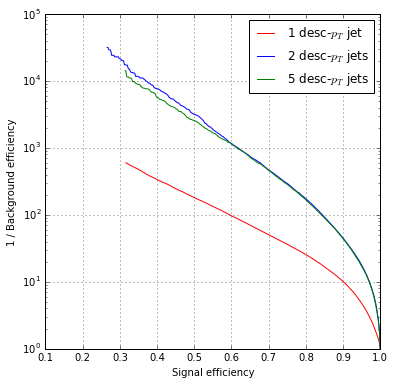

In [6]:
for pattern, n_jets, label, color in [
        ("antikt-seqpt-reversed", 1, "1 desc-$p_T$ jet", "r"),
        ("antikt-seqpt-reversed", 2, "2 desc-$p_T$ jets", "b"),
        ("antikt-seqpt-reversed", 5, "5 desc-$p_T$ jets", "g")
    ]:
    
#     r, f, t = evaluate_models("../models/event-study/predictions/predictions-e-full-%s-%d-*.pickle" % (pattern, n_jets))
#     plot_rocs(r, f, t, label=label, color=color, show_all=False)
#     report_score(r, f, t, label=label, latex=True)
    
    r, f, t = evaluate_models("../models/event-study/predictions-reversed/predictions-e-full-%s-%d-*.pickle" % (pattern, n_jets))
    plot_rocs(r, f, t, label=label, color=color, show_all=False)
    report_score(r, f, t, label=label, latex=True)
    
plot_show()

                       1 jet4v 	& 0.8909 $\pm$ 0.0007 	& 18.2 $\pm$ 0.2 \\
                       2 jet4v 	& 0.9606 $\pm$ 0.0011 	& 128.8 $\pm$ 8.5 \\
                       5 jet4v 	& 0.9576 $\pm$ 0.0019 	& 133.2 $\pm$ 7.6 \\


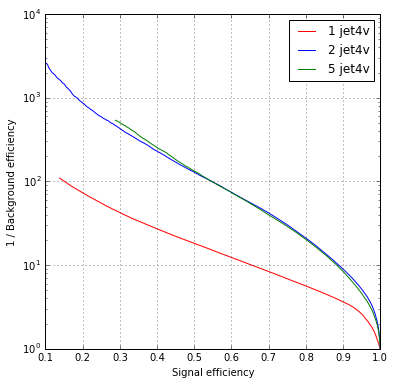

In [8]:
for pattern, n_jets, label, color in [
        ("jet4v", 1, "1 jet4v", "r"),
        ("jet4v", 2, "2 jet4v", "b"),
        ("jet4v", 5, "5 jet4v", "g")
    ]:
    
#     r, f, t = evaluate_models("../models/event-study/predictions/predictions-e-4v-%s-%d-*.pickle" % (pattern, n_jets))
#     plot_rocs(r, f, t, label=label, color=color, show_all=False)
#     report_score(r, f, t, label=label, latex=True)
    
    r, f, t = evaluate_models("../models/event-study/predictions-reversed/predictions-e-4v-%s-%d-*.pickle" % (pattern, n_jets))
    plot_rocs(r, f, t, label=label, color=color, show_all=False)
    report_score(r, f, t, label=label, latex=True)
    
plot_show()

                       1 all4v 	& 0.6501 $\pm$ 0.0023 	& 3.3 $\pm$ 0.0 \\
                      50 all4v 	& 0.8925 $\pm$ 0.0079 	& 24.9 $\pm$ 2.1 \\
                     100 all4v 	& 0.8781 $\pm$ 0.0180 	& 23.4 $\pm$ 4.3 \\
                     200 all4v 	& 0.8846 $\pm$ 0.0091 	& 25.2 $\pm$ 2.9 \\
                     400 all4v 	& 0.8780 $\pm$ 0.0132 	& 23.0 $\pm$ 4.0 \\


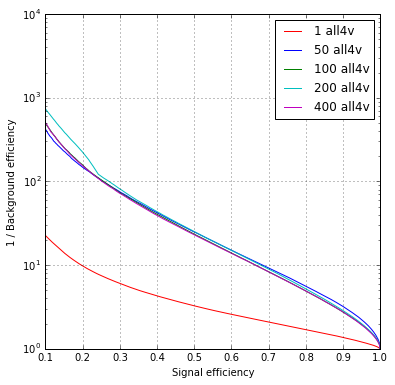

In [9]:
for pattern, n_jets, label, color in [
        ("all4v", 1, "1 all4v", "r"),
        ("all4v", 50, "50 all4v", "b"),
        ("all4v", 100, "100 all4v", "g"),
        ("all4v", 200, "200 all4v", "c"),
        ("all4v", 400, "400 all4v", "m")
    ]:
    
#     r, f, t = evaluate_models("../models/event-study/predictions/predictions-e-4v-%s-%d-*.pickle" % (pattern, n_jets))
#     plot_rocs(r, f, t, label=label, color=color, show_all=False)
#     report_score(r, f, t, label=label, latex=True)
    
    r, f, t = evaluate_models("../models/event-study/predictions-reversed/predictions-e-4v-%s-%d-*.pickle" % (pattern, n_jets))
    plot_rocs(r, f, t, label=label, color=color, show_all=False)
    report_score(r, f, t, label=label, latex=True)
    
plot_show()